# Peut-on prédire le sexe des auteurs de haïkus ?

**Python pour un data scientist - Décembre 2018**

*Auteurs : Samuel Allain, Maxime Bergeat, Gabriel Buresi*


In [1]:
import os
os.chdir("/home/samuel/ENSAE1/PYTHON/Haikus/")
print(os.getcwd())

/home/samuel/ENSAE1/PYTHON/Haikus


In [1]:
# Instruction pour ajouter le menu du notebook
from jyquickhelper import add_notebook_menu
add_notebook_menu()

INTRO A ECRIRE.

In [3]:
# Pour ne pas afficher les warnings en sortie...
import warnings
warnings.simplefilter('ignore')

## Import des librairies utilisées dans le notebook
# Récupération des données
import requests
import urllib
import bs4
import collections
import pandas as pd

# Manipulations algébriques et de données
import os
from os import path
import numpy as np
import pandas as pd
import time
from sklearn.pipeline import make_pipeline

# Statistiques descriptives
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Gestion du texte
import nltk
import nltk.corpus
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Machine learning
from sklearn import svm, datasets, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

# Visualisation résultats
import seaborn as sn
import matplotlib.pyplot as plt
% matplotlib inline

## Récupération des données

Dans cette partie, on cherche à récupérer par scraping les haïkus du site, leur contenu et quelques informations sur les auteurs, en particulier leur sexe inféré à partir de leur prénom.

On procède en deux temps : 
- On scrape la liste des url d'haïkus écrits par des écrivains francophones. Pour cela, on récupère l'ensemble des adresses des pages d'auteurs francophones sur [cette page du site Temps Libres](http://www.tempslibres.org/tl/tlphp/dbauteurs.php?lg=f). Ensuite, on récupère sur chaque page auteur (comme [ici](http://www.tempslibres.org/tl/tlphp/dbhk01.php?auteur=ahes-r&lg=f), l'ensemble des identifiants de haïkus, permettant ainsi d'avoir une liste de pages de haïkus à scraper.
- Ensuite, il s'agit de télécharger chaque page, d'en extraire le poème à partir du repérage des balises HTML puis de le ranger dans une base de de données exportée au format csv. Celle-ci est ensuite vérifiée afin de s'assurer que les haïkus correspondent à leur auteur, sont intègres, et sont en langue française.

La difficulté principale réside dans la présence occasionnelle de plusieurs haïkus par page. En effet, certains haïkus sont écrits en plusieurs langues. Dans la perspective d'une analyse lexicale, il convient de les éliminer. Hélas, la place du poème français parmi les différents poèmes n'est pas fixe, d'où le recours nécessaire à un dispositif de reconnaissance de la langue du texte. Le format court du haïku rendant approximative la reconnaissance de la langue par la fréquence des lettres, nous avons opté pour un score calculé à partir de marques du français et de marques de langues étrangères, essentiellement des mots vides ainsi que certains accents. La phase de vérification a montré une efficacité de 100% de cette méthode, au sens où 100% des poèmes scrapés étaient en français alors que les cas de langues multiples étaient fréquents. Un poème mi-français mi-anglais a été retiré manuellement.


### Récupération des URL des pages à scraper

In [4]:
### Etape 1 : récupération de l'ensemble des pages auteurs
request = urllib.request.urlopen("http://www.tempslibres.org/tl/tlphp/dbauteursl.php?lang=fr&lg=f").read()
page = bs4.BeautifulSoup(request, "html.parser")

# Récupération des auteurs
table_liens = page.find("table")
        
# Création de la liste d'URLs d'auteurs
liste_urls = []
debut_url = "http://www.tempslibres.org/tl/tlphp/"
for item in table_liens.find_all({'a'}):
    if item.get("href") :
        liste_urls.append(debut_url+item.get("href")) 

liste_urls[0:4]

['http://www.tempslibres.org/tl/tlphp/dbhk01.php?auteur=ahes-r&lg=f',
 'http://www.tempslibres.org/tl/tlphp/dbhk01.php?auteur=alex-m&lg=f',
 'http://www.tempslibres.org/tl/tlphp/dbhk01.php?auteur=alsa-m&lg=f',
 'http://www.tempslibres.org/tl/tlphp/dbhk01.php?auteur=ambr-p&lg=f']

In [5]:
## Etape 2 : création de la liste d'URLs pour l'ensemble des auteurs (suppression des éventuels doublons en aval)
debut_url = "http://www.tempslibres.org/tl/tlphp/"
liste_url_haikus = []

start_time = time.time()
for url in liste_urls:
    request = urllib.request.urlopen(url).read()
    page = bs4.BeautifulSoup(request, "html.parser")
    contenu_page_auteur = page.find("article")
    for item in contenu_page_auteur.find_all({'a'}):
        if item.get("href") :
            # Instruction pour ne garder que les URLs relatives (renvoyant sur des haïkus) et non les liens externes
            if ((item.get("href")[0:4])!="http"):
                liste_url_haikus.append(debut_url+item.get("href")) 
            
print("La récupération de l'ensemble des URLs à scraper a duré %s secondes." % round((time.time() - start_time),0))

La récupération de l'ensemble des URLs à scraper a duré 61.0 secondes.


In [6]:
# Suppression des doublons
liste_url_haikus = list(set(liste_url_haikus))
len(liste_url_haikus)

3522

In [7]:
# df = pd.DataFrame(liste_url_haikus, columns=["URL"])
# df.to_csv("liste_urls_haikus_auteurs_franco_V3_20181213.csv")

### Récupération du contenu des haïkus

A partir de la liste précédemment composée, on peut désormais récupérer l'ensemble des haïkus, en se restreignant à ceux écrits en français. À cette étape, on inclut également le sexe de l'auteur dans les données. Celui-ci a été codé manuellement à partir du prénom. Les haïkus des auteurs utilisant un pseudo, et pour lesquels nous n'avons pas trouvé d'information sur internet ont été éliminés de l'analyse.

In [8]:
##Tableau de correspondance auteurs-sexes
auteurs = pd.read_csv("Sexe_Auteurs_Haikus.csv", sep=",")

##Tableau de données rempli à l'issue de l'extraction :
haikus=pd.DataFrame(columns=["url","id_auteur", "auteur", "sexe", "pays", "haiku"])

#### Sélection des haïkus en français

Le problème des langues étrangères ne se pose que pour deux langues :
1. l'anglais, très majoritairement
2. l'espagnol, anecdotiquement

Il a paru suffisant de faire un score unique, d'autant plus élevé que le texte possède de marques du français et d'autant plus bas qu'il contient des marques de l'anglais ou de l'espagnol.

En plus des mots vides, on a rajouté des accents, y compris le "é" qui existe aussi en espagnol mais est moins fréquent qu'en français.

In [9]:
stop_words_fr = get_stop_words('french') 
stop_words_fr = [ " "+i+" " for i in stop_words_fr if len(i)>1] ## on espace les mots vides pour qu'ils ne soient pas comptablisés au sein d'un autre mot. Par exemple "the" ne doit pas être
stop_words_fr += ["é", "ê", "à", "è", "'a", "'à", "'u", "'e", "'o", "ç"]
stop_words_non_fr = get_stop_words('english') + get_stop_words('spanish')
stop_words_non_fr = [ " "+i+" " for i in stop_words_non_fr if len(i)>1]
stop_words_non_fr += ["'s", "the"]

In [10]:
def scraper(jusqua=len(liste_url_haikus)-1) :
	"""Écrit chaque haiku sur une ligne dans le fichier haikus.csv"""
	i = 0
	timestamp_initial= time.time()
	###Afficher l'avancement pour les i suivants
	i_affiches = [int(i*jusqua) for i in np.linspace(start=0, stop=1, num=11)]
	while i < jusqua :
		url_page = liste_url_haikus[i]
		page = urllib.request.urlopen(url_page).read()
		page = bs4.BeautifulSoup(page, "lxml")
		extrait = page.findAll('p', {'class' : 'dbhkanahaiku'}) ### le haïku se trouve dans un paragraphe de classe dbhkanahaiku
		extrait = str(extrait) # objet BS → chaîne de caractères
		##On retire les balises parasites
		extrait = extrait.split('class="dbhkanahaiku">')[1] #la balise initiale
		extrait = extrait.replace("</p>]", "") #la balise finale
		extrait = extrait.replace("<br/>","")
		extrait = extrait.replace("\r", "")
		##Lorsqu'il y a plusieurs poèmes, ils sont séparés par un double saut de ligne, on les enregistre dans une liste
		extrait = extrait.split("\n\n")
		### AUTEUR, IDENTIFIANT, PAYS, SEXE
		auteur = page.findAll('p', {'class' : 'dbhktlref'})
		auteur=str(auteur)
		#print(auteur)
		auteur = auteur.split("<br/>")[1]
		pays = auteur.split(",")[1]
		pays = pays.replace(" ","")
		auteur = auteur.split(",")[0]
		id_auteur = str(page).split("auteur=")[1]
		id_auteur = id_auteur.split("&")[0]
		#id_auteur = id_auteur + " "
		print(auteur, "    ", id_auteur, "                              ", sep="", end="\r")
		sexe = auteurs[(auteurs["Page"] == id_auteur)]["Sexe"] ##On utilise l'identifiant de l'auteur pour le retrouver dans le tableau de correspondance auteurs-sexes
		sexe = sexe.iloc[0]
		id_auteur = id_auteur.replace(" ", "")
		#### Boucle pour calculer le score de langue de chaque poème de la liste
		j = 0
		scores = []
		while j < len(extrait) :
			haiku = extrait[j].replace("\n", "\\\\")
			contenu = haiku.replace("\\\\", " ")
			score = 0 
			for caract in stop_words_fr :
				score = score + (caract in contenu)
			for caract in stop_words_non_fr :
				score = score - (caract in contenu)
			#print(url_page, contenu)
			scores.append(score)
			#print(scores[j])
			j += 1
		m = max(scores) ##On enregistre le score du poème le « plus » français
		if m > 0 : ##on ne prend le poème le « plus » français que si son score est positif, ie si le français l'emporte
			indice = [i for i, j in enumerate(scores) if j == m][0]
			haiku = extrait[indice].replace("\n", "\\\\") ##On adopte le signe \\ pour marquer les retours à la ligne
			haikus.loc[len(haikus)] = [url_page, id_auteur, auteur, sexe, pays, haiku] ## ajouter le poème à la liste
		##Calcul d'un pourcentage d'avancement de l'opération de scraping
		avancement = round(100*i/jusqua,1)
		if i in i_affiches:
			timestamp_intermediaire = time.time()
			duree_moyenne = (timestamp_intermediaire-timestamp_initial)/(i+1)
			duree_restante = duree_moyenne*(jusqua+1-i)
			print(avancement, "%", "    ", "i=", i, "     Temps estimé : ", int(round(duree_restante//60,0)), " minutes et ", int(round(duree_restante%60,0)), " secondes", sep="")
			print("==============================================================")
			haikus.to_csv("sauvegarde.csv") ####on fait des sauvegardes régulières
		i += 1
	print("Nombre de poèmes scrapés : ", jusqua, "     Temps total : ", int((timestamp_intermediaire-timestamp_initial)//60), " minutes et ", int((timestamp_intermediaire-timestamp_initial)%60), " secondes", sep="")
	t = time.localtime()
	haikus.to_csv("haikus"+"_"+str(t.tm_year)+"_"+str(t.tm_mon)+"_"+str(t.tm_mday)+"_"+str(t.tm_hour)+"h.csv", index=False)
	return(haikus)
#haikus = scraper(jusqua=10) ## Tester sur les 10 premiers urls
haikus = scraper() ## Sur tous les url
haikus.head()

0.0%    i=0     Temps estimé : 15 minutes et 13 secondes
10.0%    i=352     Temps estimé : 17 minutes et 12 secondes       
20.0%    i=704     Temps estimé : 15 minutes et 10 secondes       
30.0%    i=1056     Temps estimé : 13 minutes et 11 secondes          
40.0%    i=1408     Temps estimé : 11 minutes et 14 secondes      
50.0%    i=1760     Temps estimé : 9 minutes et 37 secondes           
60.0%    i=2112     Temps estimé : 7 minutes et 51 secondes           -pd                              
70.0%    i=2464     Temps estimé : 6 minutes et 2 secondes        
80.0%    i=2816     Temps estimé : 4 minutes et 3 secondes            
90.0%    i=3168     Temps estimé : 2 minutes et 2 secondes        
Nombre de poèmes scrapés : 3521     Temps total : 18 minutes et 13 secondes


,url,id_auteur,auteur,sexe,pays,haiku
0,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,chev-h,Henri Chevignard,H,France,au dernier rang du spectacle de mime - torticolis
1,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,dudo-d,Denise Dudon,F,France,tête levée\\le cheval cueille aux branches\\la...
2,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,hoar-v,Vincent Hoarau,H,France,dans la soie noire\\de sa robe de nuit\\l'hive...
3,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,holl-m,Mark Holloway,H,UK,solstice d'hiver\\la langue rose d'un chat\\lè...
4,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,mena-pd,Paul David Mena,H,USA,givre sur le pare-brise --\\je me souviens com...


## Statistiques descriptives 

Pour commencer, on produit quelques statistiques descriptives sur les haïkus de la base de données, notamment pour savoir les mots les plus fréquemment cités par les hommes et les femmes.

In [11]:
# Import des données 
haikus = pd.read_csv("haikus_2018_12_1321h.csv")
haikus.head()

,url,id_auteur,auteur,sexe,pays,haiku
0,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,macr-c,Carole MacRury,F,USA,nettoyage de printemps . . . \\je peins sur\\l...
1,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,gabr-d,Damien Gabriels,H,France,seul ce matin -\\l'arête coupante\\de mon bol...
2,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,alsa-m,Mohamad Alsari,H,Syria,La cour de la prison\\dans la flaque de la plu...
3,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,darn-b,Brian Austin Darnell,H,USA,bois en automne -\\l'odeur\\de la pluie de la ...
4,http://www.tempslibres.org/tl/tlphp/dbhk03.php...,gabr-d,Damien Gabriels,H,France,croisée de chemins -\\le genévrier\\s'est arrê...


In [12]:
print("On dispose de " +str(len(haikus))+" haïkus dans la base de données scrapée.")

On dispose de 3319 haïkus dans la base de données scrapée.


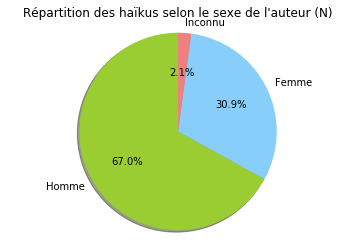

In [13]:
# Nombre de haïkus selon le sexe de l'auteur.
labels = 'Homme', 'Femme', 'Inconnu'
freq = list(haikus['sexe'].value_counts())
colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
plt.pie(freq, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Répartition des haïkus selon le sexe de l'auteur (N)")
plt.show()

Pour quelques haïkus, on ne connaît pas le sexe de l'auteur. Ces haïkus seront retirés de l'analyse par la suite pour coder le sexe de l'auteur. On constate que le jeu de données n'est pas complètement équilibré (plus d'hommes que de femmes dans les données). Certaines méthodes utilisées ensuite pour la classification vont conduire à prédire beaucoup plus souvent que les auteurs sont des hommes que des femmes. Nous discuterons cet élément.

Par ailleurs, différents tests ont été réalisés pour construire un jeu de données équilibré avec 50% de haïkus écrits par des femmes. Les résultats en termes de pouvoir prédictif n'améliorant pas significativement les modèles, ces résultats ne sont pas présentés, et l'on s'appuie dans la suite sur le jeu de données initial après avoir retiré les haïkus pour lesquels le sexe de l'auteur est inconnu.

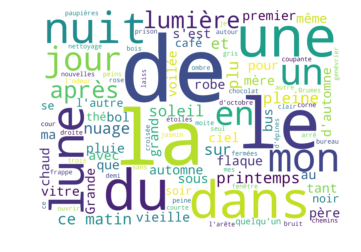

In [14]:
# Nuage de mots pour indiquer les mots les plus cités par les auteurs de haïkus
mots_haikus = str(haikus["haiku"])
wordcloud = WordCloud(background_color='white',
                          width=2500,
                          height=1800, 
                        max_words=100).generate(mots_haikus)

# Affichage du nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

On constate ici que les mots les plus souvent cités par les auteurs de haïkus sont des mots vides de sens comme des articles. On va donc effectuer la représenation sous forme de nuage de mots en excluant les mots vides (*stopwords*).

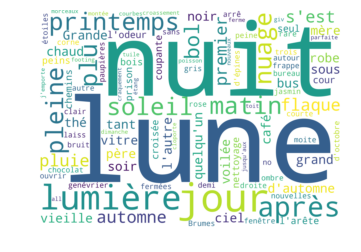

In [15]:
# Création de la liste de stopwords. On utilise la liste de la librairie nltk en ajoutant "les" qui ne figure pas 
# dans la liste initiale.
mots_vides = nltk.corpus.stopwords.words('french')
mots_vides.append("les")
stopwords=set(mots_vides)

# Nuage de mots amélioré
wordcloud2 = WordCloud(   stopwords=stopwords,
                          background_color='white',
                          width=2500,
                          height=1800, 
                        max_words=100, 
                         ).generate(mots_haikus)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.show()

On note que les mots les plus cités font souvent référence à la nature (**ciel**, **lune**, **soleil**...). Cela est dû à la **règle du kigo** que doivent respecter les auteurs de haïkus. La règle du kigo indique en effet que chaque haïku doit comporter un kigo, c'est-à-dire un "mot de saison" faisant référence à la nature ou à l'une des quatre saisons. En effet,la représentation des saisons est très importante dans la culture japonaise (https://fr.wikipedia.org/wiki/Kigo). On s'intéresse maintenant aux mots les plus cités par les hommes et les femmes.

Text(0.5,1,'Mots les plus fréquents pour les haïkus écrits par des hommes')

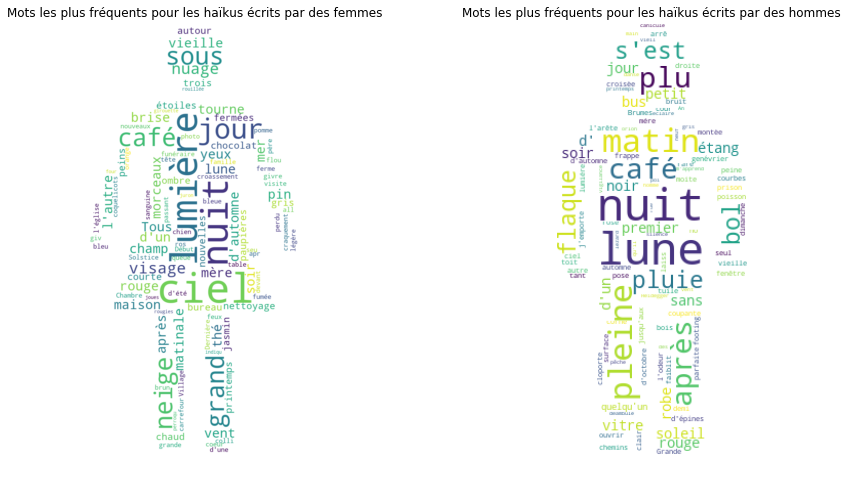

In [16]:
# Jeux de données séparés pour les hommes et les femmes.
haikus_F = str(haikus[haikus['sexe'] == "F"]["haiku"])
haikus_H = str(haikus[haikus['sexe'] == "H"]["haiku"])

# Pour les femmes
masqueF = np.array(Image.open("images/symbole-femme.png"))
wordcloud_femmes = WordCloud(stopwords=stopwords, 
                             background_color="white", 
                             #mode="RGBA", 
                             max_words=100, 
                             mask=masqueF).generate(haikus_F)

# Pour les hommes
masqueH = np.array(Image.open("images/symbole-man2.png"))
wordcloud_hommes = WordCloud(stopwords=stopwords, 
                             background_color="white", 
                             mode="RGBA", 
                             max_words=100, 
                             mask=masqueH).generate(haikus_H)

# Tracé sur un même graphique
fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(1,2,1)
plt.imshow(wordcloud_femmes, interpolation="bilinear")
plt.axis("off")
plt.title("Mots les plus fréquents pour les haïkus écrits par des femmes")
ax2 = fig.add_subplot(1,2,2)
plt.imshow(wordcloud_hommes, interpolation="bilinear")
plt.axis("off")
plt.title("Mots les plus fréquents pour les haïkus écrits par des hommes")

On constate effectivement quelques différences. Par exemple, le mot **ciel** est plus souvent employé par des femmes, alors que les hommes utilisent plus souvent le mot **lune**. Pour essayer d'exploiter ces différences, on met en place des modèles d'apprentissage supervisé (*machine learning*) afin de prédire le sexe des auteurs de haïkus.

## Modèles de classification

Pour effectuer la classification, on considère l'ensemble des mots comme prédicteurs, et on teste différents modèles pour prédire le sexe. Plusieurs paramétrages ont été testés mais seulement certains sont présentés dans ce notebook :
- En ce qui concerne l'inclusion des *stopwords* dans l'analyse, il a été décidé des les inclure étant donné que les textes étudiés sont très courts. Les résultats sont similaire si les *stopwords* sont utilisés dans les modèles.
- Différents paramétrages ont été testés pour utiliser des *1*-grammes, *2*-grammes ou *3*-grammes dans les modèles de classification. Les résultats sont ici présentés en considérant comme régresseurs potentielles tous les *1*-grammes, *2*-grammes et *3*-grammes dans les données. Toutefois, les résultats sont relativement similaires en ne prenant en compte que les *1*-grammes (mots).
- Pour obtenir la matrice document-terme servant de base à l'analyse, nous avons testé l'utilisation de variables dichotomiques (présence ou non de chaque n-gramme dans le haïku) ou bien la mobilisation du score *tf-idf* pour pondérer chaque *n*-gramme en fonction de sa rareté dans le corpus de haïkus à disposition (en effet, la pondération en *tf* joue peu ici étant donné qu'il est rare qu'un mot soit répété plus d'une fois dans un même haïku !). Les résultats sont ici présentés avec l'application de la pondération *tf-idf*. Bien que cela soit théoriquement plus acceptable d'utiliser cette pondération (pour notamment sous-pondérer les *stopwords*), son application n'améliore pas de façon importante le pouvoir prédictif des modèles par rapport à la mobilisation de variables dichotomiques.
- Le nombre de variables disponibles pour la prédiction est donc très important (plus de variables que d'observations). Une application de méthode d'analyse de données (Analyse en Composantes Principales) pour réduire la dimensionnalité des variables utilisées pour la classification est présentée en conclusion du notebook.


### Création des jeux de données pour l'entraînement et la validation des modèles 

In [17]:
# On ne conserve que les auteurs pour lesquels le sexe est déterminé, et on crée 
# les jeux d'apprentissage et de validation.
haikus_model = haikus[haikus.sexe != "?"]


X_train, X_test, y_train, y_test = train_test_split(
               haikus_model['haiku'], haikus_model["sexe"])
print("On dispose de " +repr(len(haikus_model))
      +" haïkus dans la base de données utilisée pour la classification.")

On dispose de 3248 haïkus dans la base de données utilisée pour la classification.


In [18]:
# Création des variables utilisées pour la classification.
# On considère ici l'ensemble des 1-grammes, 2-grammes et 3-grammes, et on applique une transformation tf-idf.

pipe = make_pipeline(CountVectorizer(ngram_range=(1,3)), TfidfTransformer())

pipe.fit(X_train)
feat_train = pipe.transform(X_train)

feat_test = pipe.transform(X_test)
feat_test.shape

(812, 37554)

On dispose donc en considérant l'ensemble des *3*-grammes des données qu'on dispose d'un nombre très important de variables mobilisables pour la classification (près de 40 000). Pour la suite, on présente :
- Des résultats comparatifs sur quatre modèles simples utilisés en apprentissage supervisé : forêts aléatoires, régression logistique, classifieur naïf bayésien et réseaux de neurones
- Une discussion sur l'affinage des hyper-paramètres des modèles.
- Une extension concernant la réduction de la dimensionnalité pour les variables utilisées pour la prédiction

### Comparaison entre quatre modèles

Pour chacun des modèles, on s'intéresse au pouvoir de prédiction du sexe des auteurs. On mesure ce pouvoir à l'aune d'un *benchmark*, en l'occurence un classifieur idiot qui prédit le sexe de l'auteur en fonction de la distribution observée sur les données initiales.

#### Modèle idiot

In [19]:
idiot = DummyClassifier(strategy="stratified")
# Entraînement modèle
idiot.fit(X=feat_train, y= y_train)
# Prédiction sur le jeu test
s = idiot.score(X=feat_test, y= y_test)
print(str(s)+"\n")
s= int(100*s)
print("En moyenne avec le modèle idiot, on prédit correctement le sexe de l'auteur pour {}% des haïkus de la base de test.".format(s))

0.5554187192118226

En moyenne avec le modèle idiot, on prédit correctement le sexe de l'auteur pour 55% des haïkus de la base de test.


#### Forêts aléatoires

In [20]:
## Forêt aléatoire avec 50 arbres
foret = RandomForestClassifier(n_estimators=50)
# Entraînement modèle
foret.fit(feat_train, y_train)
# Prédiction sur le jeu test
foret.score(feat_test, y_test)

0.666256157635468

Le score ici présenté est celui de l'exactitude. Sur la base de données de test, il correspond au nombre de haïkus dont le sexe de l'auteur est bien identifié. Pour préciser les résultats, on peut tracer la matrice de confusion.

Text(33,0.5,'Sexe à prédire')

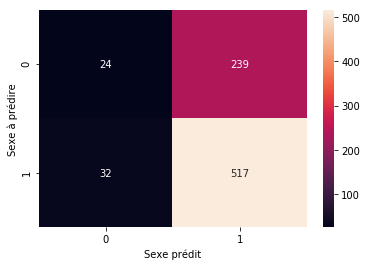

In [21]:
## Visualisation avec package sns (carte de chaleur)
y_pred = foret.predict(feat_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

#### Régression logistique 

In [22]:
# On utilise ici la pénalité l1 (résultats similaires avec pénalité l2)
lreg = LogisticRegression(penalty= "l2") 
# Entraînement modèle 
lreg.fit(X= feat_train, y=y_train)
# Prédiction sur le jeu test
lreg.score(X=feat_test, y=y_test)

0.6773399014778325

Text(33,0.5,'Sexe à prédire')

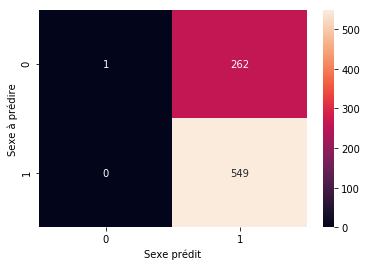

In [23]:
y_pred = lreg.predict(feat_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

On constate ici que le modèle prédit presque exclusivement que les auteurs sont des hommes. Ce désavantage de la méthode de régression logistique est dû au fait que le jeu de données comporte plus d'auteurs masculins que féminins.

#### Classifieur naïf bayésien

In [24]:
## NB : pour cette méthode, on doit convertir les matrices 
# avec les régresseurs pour avoir des objets non sparse.
feat_train_nosparse = feat_train.toarray()
feat_test_nosparse =feat_test.toarray()

bayes = GaussianNB()
# Entraînement modèle
bayes.fit(feat_train_nosparse, y_train)
# Prédiction sur le jeu test
bayes.score(feat_test_nosparse, y_test)

0.6317733990147784

Text(33,0.5,'Sexe à prédire')

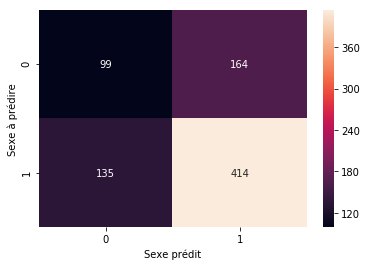

In [25]:
y_pred = bayes.predict(feat_test_nosparse)
cnf_matrix = confusion_matrix(y_test, y_pred)
matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

Contrairement au modèle de régression logistique, le modèle ne prédit pas que des auteurs masculins.

#### Réseau de neurones

In [26]:
# Réseau de neurones - on utilise ici un modèle de réseau de neurones
# multi-layer perceptron, avec jusqu'à 100 couches cachées.
reseau_neur = MLPClassifier(hidden_layer_sizes=(100,))
# Entraînement modèle
reseau_neur.fit(X=feat_train, y= y_train)
# Prédiction sur le jeu test
reseau_neur.score(X=feat_test, y= y_test)

0.6588669950738916

Text(33,0.5,'Sexe à prédire')

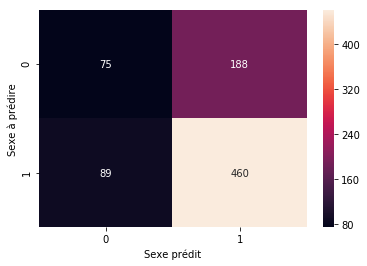

In [27]:
y_pred = reseau_neur.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True, fmt ="d")
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

Un important avantage de la classification avec réseau de neurones est que le modèle prédit plus souvent d'auteurs féminins (dans des proportions similaires à la proportion observée dans les données). L'exactitude du modèle est aux alentours de 70%, soit un score proche des modèles précédents

#### Comparaison des modèles précédents avec courbes Roc

In [28]:
### Courbes ROC pour comparer les différentes approches.
np_train = np.hstack([feat_train.todense()])
np_test = np.hstack([feat_test.todense()])
pmodelIdiot = idiot.predict_proba(np_test)[:, 1]
pmodelFor = foret.predict_proba(np_test)[:, 1]
pmodelreg = lreg.predict_proba(np_test)[:, 1]
pmodelBayes = bayes.predict_proba(np_test)[:, 1]
pmodelResNeur = reseau_neur.predict_proba(np_test)[:, 1]


In [29]:
# Conversion de l'objet y en numérique (0/1 plutôt que homme/femme pour pouvoir tracer la courbe)
y_test_num= (y_test == "H")
fpr1, tpr1, th1 = roc_curve(y_test_num, pmodelIdiot)
fpr2, tpr2, th2 = roc_curve(y_test_num, pmodelFor)
fpr3, tpr3, th3 = roc_curve(y_test_num, pmodelreg)
fpr4, tpr4, th4 = roc_curve(y_test_num, pmodelBayes)
fpr5, tpr5, th5 = roc_curve(y_test_num, pmodelResNeur)

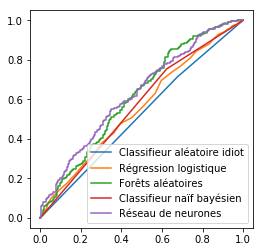

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='Classifieur aléatoire idiot')
ax.plot(fpr2, tpr2, label='Régression logistique')
ax.plot(fpr3, tpr3, label='Forêts aléatoires')
ax.plot(fpr4, tpr4, label='Classifieur naïf bayésien')
ax.plot(fpr5, tpr5, label='Réseau de neurones')

ax.legend();

On constate que les modèles ici utilisés sont légèrement meilleurs que le modèle idiot qui reproduit la proportion observée dans les données initiales. Toutefois, les scores d'exactitude observées restent relativement faibles, aux alentours de 70%, ce qui laisse supposer qu'il est en fait difficile de prédire le sexe des auteurs de haïkus, ce qui semble assez logique étant donné le peu de textes à disposition. Pour préciser les résultats, on peut comparer les modèles en construisant divers jeux d'apprentissage et de test (validation croisée). 

Un écueil important de certains modèles testés (notamment régression logistique) est qu'ils prédisent un sexe masuclin pour la quasi-totalité des auteurs étudiés. Pour pallier cette difficulté, on va utiliser une autre métrique pour comparer les modèles dans la suite. On utilisera le score **f1_macro**, qui est une moyenne non pondéré du score F1 pour les hommes et pour les femmes. Le score F1 est défini pour une catégorie comme la moyenne géométrique de la précision (part de bien classés parmi les personnes codées comme une catégorie) et du rappel (proportion d'enregistrements retrouvés pour les observations de cette catégorie). Ainsi, le score F1 pour les femmes vaudra 0 dans le cas où le modèle ne prédit que des auteurs masculins ce qui sera donc très pénalisant.

#### Comparaison des modèles avec validation croisée

In [ ]:
## On crée les données à partir de la base initiale
# (le découpage apprentissage/test est effectué 10 fois 
# car on utilise la validation croisée ici)
X = pipe.transform(haikus_model['haiku']).toarray()
Y = haikus_model['sexe']

t_debut = time.time()

# Apprentissage des modèles
models = []
models.append(("Idiot", DummyClassifier(strategy="stratified")))
models.append(('Reg Log', LogisticRegression(penalty = "l1")))
models.append(('Forêts a.', RandomForestClassifier(n_estimators=50)))
models.append(('Réseaux n.', MLPClassifier()))
models.append(('Naïf bayésien', GaussianNB()))
# evaluate each model in turn

results = []
names = []
scoring = 'f1_macro'

# Evaluation de chaque modèle à partir de validation croisée 
# Ici on effectue la 10-fold validation croisée
# Le score considéré ici est le score F1 macro comme indiqué.
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
t_fin = time.time() 
temps_exec = t_fin - t_debut
print("L'ajustement de l'ensemble de ces modèles a duré "+str(int(temps_exec//60))+" minutes et "+ str(int(temps_exec%60)) +" secondes.")

Idiot: 0.498024 (0.035086)


/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/samuel/anaconda3/lib/p

Reg Log: 0.408858 (0.009425)
Forêts a.: 0.454624 (0.018482)


In [ ]:
# Tracé de l'ensemble des résultats (scores F1)
fig = plt.figure()
fig.suptitle('Comparaison de divers algorithmes pour coder le sexe - Métrique utilisée : score F1 - Validation croisée')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

On constate ici que, lorsque la métrique F1 est utilisée pour comparer les modèles, pénalisant ainsi plus fortement les modèles ayant tendance à prédire seulement des auteurs masculins, la classification avec des réseaux de neurones ou des classificateurs naïfs bayésiens obtiennent de meilleures performances. Encore une fois, on constate que les meilleurs modèles obtiennent seulement des performances légèrement supérieures à celles du modèle idiot. On en conclut qu'il est difficile de prédire le sexe des auteurs de haïkus seulement à partir du texte, ce dernier étant peut-être trop court.

### Discussion : affinage des hyperparamètres

Dans la section précédente, la plupart des paramètres choisis pour les modèles étaient les paramètres par défaut des méthodes utilisées. On peut également tester une multitude de modèles avec différents hyperparamètres de façon à optimiser les modèles. Cela a été fait pour l'ensemble des modèles présentés ci-dessus, mais nous nous concentrons ici sur quelques intuitions pour les forêts aléatoires. On fait varier trois types de paramètres :
- le nombre maximum de *n-*grammes utilisées pour un arbre
- la profondeur maximale de l'arbre
- le nombre minimum d'observations par noeud terminal

D'autres paramètres peuvent également varier (comme par exemple le nombre d'arbres par forêt). L'optimisation se fait ici sur le score F1, pour pénaliser plus fortement les modèles qui prédisent toujours des hommes.

In [ ]:
t_debut = time.time()

parameters = {'max_features':("auto", "log2", 500, 1000, None),
             'max_depth':[None, 100, 50, 30, 20, 10],
              'min_samples_leaf':[1,2,5,10,20]}
# On utilise comme score le score F1 pour une moyenne du rappel et de la précision.
svc = RandomForestClassifier()
clf = GridSearchCV(svc, parameters, cv=5, scoring = "f1_macro")
clf.fit(feat_train, y_train)

t_fin = time.time() 
temps_exec = t_fin - t_debut
print("Le fitting de l'ensemble de ces modèles a duré "+repr(temps_exec)+" secondes.")

In [ ]:
# Modèle sélectionné
clf.estimator

In [ ]:
clf.score(feat_test, y_test)

In [ ]:
# Matrice de confusior pour le "meilleur" modèle
# (au sens du score F1)
y_pred = clf.predict(feat_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

On constate ici que le modèle sélectionné n'a pas le défaut de coder trop souvent des hommes comme dans la partie précédente (optimisation opérée sur le critère du score F1). En revanche, le score du modèle mesuré par l'exactitude avec les prédictions réalisées est très mauvais (53% ici).

### Extension : réduction de la dimensionnalité

Jusqu'ici, le nombre de variables (*3-*grammes) utilisées dans les modèles est très important (de l'ordre de 40000). En amont de la modélisation, il est également possible de réduire la dimensionnalité pour ces variables afin de limiter le nombre maximal de covariables. Même si l'interprétabilité des modèles résultants s'en trouve affaiblie, cette approche peut permettre d'améliorer le pouvoir prédictif des modèles. On présente ici quelques résultats après avoir effectué une Analyse en Composantes Principales pour les données. D'autres méthodes non linéaires peuvent également être utilisées (approche *Word2Vec*) mais elles n'ont pas été testées.

In [ ]:
pipe_svd = make_pipeline(CountVectorizer(ngram_range=(1,3)), 
                         TfidfTransformer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train)
feat_train_svd = pipe_svd.transform(X_train)
feat_train_svd.shape

In [ ]:
clf_svd = RandomForestClassifier(n_estimators=50)
clf_svd.fit(feat_train_svd, y_train)

In [ ]:
feat_test_svd = pipe_svd.transform(X_test)
clf_svd.score(feat_test_svd, y_test)

In [ ]:
y_pred = clf_svd.predict(feat_test_svd)

cnf_matrix = confusion_matrix(y_test, y_pred)


matrice_a_tracer = pd.DataFrame(cnf_matrix)

plt.figure()
sn.heatmap(matrice_a_tracer, annot=True)
plt.xlabel("Sexe prédit")
plt.ylabel("Sexe à prédire")

Pour conclure, il est difficile de prédire le sexe des auteurs de haïkus à partir du seul texte de ces derniers. Plusieurs méthodes d'apprentissage supervisé ont été testées et donnent des résultats relativement similaires en termes d'exactitude, avec environ 70% de taux de bon codage. Toutefois, certaines méthodes ont tendance à ne prédire que des auteurs masculins, comme la régression logistique avec les paramètres choisis ici. Les méthodes fondées sur les réseaux de neurones ou la classificatio naïve bayésienne peuvent apparaître plus adaptées. Dans la suite, on considère le modèle XXX et on étudie plus précisément les résultats en fonctions des probabilités prédites que l'auteur soit un homme. 

In [ ]:
### Enregistrement probabilités prédites et variable à prédire pour le modèle sélectionné (notebook suivant).
probasPreditesNN = pd.DataFrame(reseau_neur.predict_proba(feat_test))
sexe_predit = pd.DataFrame(reseau_neur.predict(feat_test))
sexe_reel = pd.DataFrame(y_test)
sexe_predit.index = sexe_reel.index
probasPreditesNN.index = sexe_reel.index
haiku = pd.DataFrame(X_test)
resultat_NN = pd.concat([haiku, sexe_reel, sexe_predit, probasPreditesNN], axis=1)
resultat_NN.columns = ['Haiku', 'Sexe réel', 'Sexe prédit', 'Proba prédite homme', 'Proba prédite femme']
resultat_NN.to_csv("dataset_pour_analyse_econometrique_v1_20181211.csv")